<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/toxic3_97_81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install glove_python_binary

     |████████████████████████████████| 952kB 7.7MB/s 


In [ ]:
from glove import Corpus, Glove

# 사전작업

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Flatten
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
#데이터
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
X_train_raw = train_data["comment_text"]
X_test_raw = test_data["comment_text"]

bad_comment_cat = ['toxic', 'severe_toxic', 'obscene', 'threat',\
       'insult', 'identity_hate']
Y_train = train_data[bad_comment_cat]

In [ ]:
print("X train shape : ", X_train.shape)
print("X test shape : ", X_test.shape)
print("y train shape : ", y_train.shape)

X train shape :  (159571,)
X test shape :  (153164,)
y train shape :  (159571, 6)


# 토큰화 작업하기

In [ ]:
max_features=150000
maxlen=200
embed_size=300

tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train_raw)
tok.fit_on_texts(X_test_raw)
X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train_raw),
                        maxlen = maxlen, truncating = "pre")
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test_raw),
                       maxlen = maxlen, truncating = "pre")

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(143613, 200)   (143613, 6)   (15958, 200)   (15958, 6)


# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, embed_size)(input)
layer = SpatialDropout1D(0.1)(layer)
layer = Bidirectional(GRU(200, return_sequences=True,dropout=0.25,recurrent_dropout=0.25,implementation=1))(layer)
layer = Conv1D(128, kernel_size = 3)(layer)   
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
layer= Dense(6, activation="sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     45000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 400)     602400      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
hist_GRU = model.fit(x_train, y_train, epochs=2,batch_size=128, validation_data=(x_val,y_val))

Epoch 1/2
1122/1122 [==============================] - 1978s 2s/step - loss: 0.0894 - accuracy: 0.8542 - val_loss: 0.0448 - val_accuracy: 0.9907
Epoch 2/2
1122/1122 [==============================] - 1924s 2s/step - loss: 0.0384 - accuracy: 0.9489 - val_loss: 0.0447 - val_accuracy: 0.9853


In [ ]:
model.save('/content/drive/MyDrive/toxic1_model3.h5')

In [ ]:
hist_LSTM = load_model('/content/drive/MyDrive/toxic1_model1.h5')

In [ ]:
model_nums = 2
size1 = x_train.shape[0]

y_train_pred = np.zeros((model_nums,size1,6),dtype="float32")
y_train_pred[0] = hist_LSTM.predict(x_train)
y_train_pred[1] = model.predict(x_train)

size2 = X_test.shape[0]
y_test_pred = np.zeros((model_nums,size2,6),dtype="float32")
y_test_pred[0] = hist_LSTM.predict(X_test)
y_test_pred[1] = model.predict(X_test)

y_pred = np.zeros((size2,6),dtype="float32")

for i in range(6):
    lg = LogisticRegression()
    temp = np.zeros((size1,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_train_pred[j,:,i]
    lg.fit(temp,y_train[bad_comment_cat[i]])

    temp = np.zeros((size2,model_nums),dtype="float32")
    for j in range(model_nums):
        temp[:,j] = y_test_pred[j,:,i]
    y_pred[:,i] = lg.predict_proba(temp)[:,1]

ValueError: ignored

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission3.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

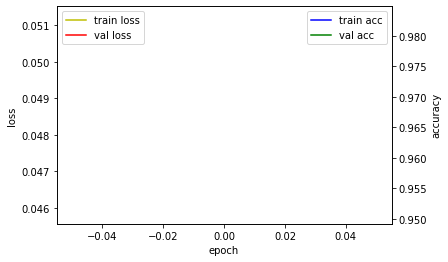

In [ ]:
acc_loss_plot(hist)